<span style="font-size: 20pt;"><span style="font-weight: bold;">Chapter 7.</span>Accessing APIs including Twitter and Reddit</span>

Last update: 12 January 2024

Thank you for checking out the code for: 

> Hogan, Bernie (2023) _From Social Science to Data Science_. London, UK. Sage Publications. 

This notebook contains the code from the book, along with the headers and additional author notes that are not in the book as a way to help navigate the code. You can run this notebook in a browser by clicking the buttons below. 
    
The version that is uploaded to GitHub should have all the results pasted, but the best way to follow along is to clear all outputs and then start afresh. To do this in Jupyter go the menu and select "Kernel -> Restart Kernel and Clear all Outputs...". To do this on Google Colab go to the menu and select "Edit -> Clear all outputs".
    
The most up-to-date version of this code can be found at https://www.github.com/berniehogan/fsstds 

Additional resources and teaching materials can be found on Sage's forthcoming website for this book. 

All code for the book and derivative code on the book's repository is released open source under the  MIT license. 
    

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/berniehogan/fsstds/main?filepath=chapters%2FCh.07.APIsRedditTwitter.ipynb)[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berniehogan/fsstds/blob/main/chapters/Ch.07.APIsRedditTwitter.ipynb)

<span style="font-size: 20pt;">📺 YouTube Video lecture for this chapter 📺</span>

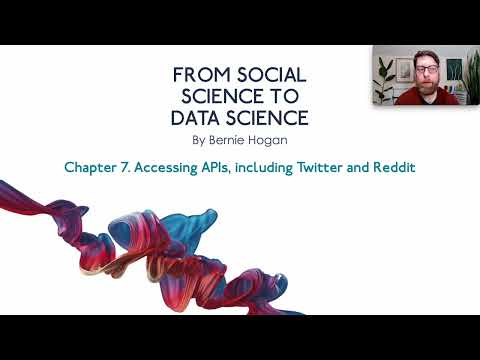

In [17]:
from IPython.display import YouTubeVideo

YouTubeVideo('iSpAXbr9l34')

# Accessing APIs: Abstracting from the web 

## Identifying yourself: Keys and Tokens

In [1]:
import requests

In [2]:
my_external_ip = requests.get("https://api.ipify.org").text
print(my_external_ip.split(".")[0] + ".xxx.xxx.xxx")

51.xxx.xxx.xxx


In [3]:
import json 

In [9]:
s = requests.Session()
s.headers.update({'x-api-key': 'aa1111bb-2222-22cc-dd3e-e44ffff5a66b'})

req = s.get("https://api.thecatapi.com/v1/breeds/search?q=Norwegian")
results = json.loads(req.content)

if len(results) > 0:
    print("Name:",results[0]['name'],
          "Description:",results[0]['description'], sep="\n")

Name:
Norwegian Forest Cat
Description:
The Norwegian Forest Cat is a sweet, loving cat. She appreciates praise and loves to interact with her parent. She makes a loving companion and bonds with her parents once she accepts them for her own. She is still a hunter at heart. She loves to chase toys as if they are real. She is territorial and patrols several times each day to make certain that all is fine.


## Securely using credentials

In [4]:
import os 

In [ ]:
print(os.environ['CONDA_PYTHON_EXE'])

In [7]:
# pip install python-dotenv
import dotenv

ENV_PATH = f"..{os.sep}.env"

In [ ]:
dotenv.set_key(ENV_PATH, 
    "CAT_API_KEY","aa1111bb-2222-22cc-dd3e-e44ffff5a66b")

In [ ]:
dotenv.load_dotenv(ENV_PATH)
print(os.environ.get('CAT_API_KEY'))

In [9]:
s = requests.Session()
s.headers.update({"x-api-key":os.environ['CAT_API_KEY']})

req = s.get("https://api.thecatapi.com/v1/breeds/search?q=Norwegian")
print(json.loads(req.content)[0]['temperament'])

Sweet, Active, Intelligent, Social, Playful, Lively, Curious


# Accessing Twitter Data through the API

In [10]:
# dotenv.set_key(ENV_PATH, "TWITTER_BEARER_TOKEN",
# "AAAAAAAAAAAAAAAAAAAAAI4bbbCCCCCCCCdEf%1GGggGgGgGgGGG222jk4l55%5LmMMmm66Nnn
# 6OOooooPpPPp7qqqQ8rrrrr999r0SSSSSSS00tTt")

dotenv.load_dotenv(ENV_PATH) # This will refresh the environment variables
print(len(os.environ.get('TWITTER_BEARER_TOKEN')))

114


In [11]:
url = "https://api.twitter.com/2/tweets/search/recent"

BEARER = os.environ["TWITTER_BEARER_TOKEN"]
headers = {"Authorization": f"Bearer {BEARER}"}

QUERY = "(muppet show) -is:retweet"
MAX_RESULTS = 10 

params={"query": QUERY,
        "max_results":MAX_RESULTS}

response = requests.get(url, headers=headers, params=params)

assert response.status_code == 200, \
    f"Code {response.status_code}. See error: {response.json()}"

tweets = response.json()
print(tweets.keys())

dict_keys(['data', 'meta'])


## Troubleshooting requests 

In [ ]:
tweets['data'][0] # Actual content simulated for book 

## Access rights and twitter. 

## Strategies for navigating Twitter's API

In [13]:
params={
    'query': QUERY,
    'max_results':10,
    'tweet.fields':"id,author_id,conversation_id,created_at,"+
                   "in_reply_to_user_id"}

response = requests.get(url, headers=headers, params=params)

assert response.status_code == 200, \
    f"Code {response.status_code}. See error: {response.json()}"

tweets = response.json()
print(tweets.keys())

dict_keys(['data', 'meta'])


In [ ]:
tweets['data'][0]

In [16]:
import pandas as pd 

In [ ]:
df = pd.json_normalize(tweets['data'])
df[["id","conversation_id","author_id","in_reply_to_user_id"]]

In [16]:
params['expansions'] = "author_id,geo.place_id"
params['user.fields'] = "id,username,name,description,public_metrics"
params['place.fields'] = "id,country,country_code,full_name"

response = requests.get(url, headers=headers, params=params)

assert response.status_code == 200, \
    f"Code {response.status_code}. See error: {response.json()}"

tweets = response.json()
print(tweets.keys())

dict_keys(['data', 'includes', 'meta'])


In [ ]:
users_df = pd.json_normalize(tweets['includes']['users'])
users_df.iloc[0]

### Using Tweet counts to manage requests  

In [18]:
params={'query': QUERY}
url = "https://api.twitter.com/2/tweets/counts/recent"

response = requests.get(url, headers=headers, params=params)

assert response.status_code == 200, \
    print("There was an error retrieving the results:", response)

count_data = response.json()

len(count_data["data"])

169

In [20]:
count_data["meta"]

{'total_tweet_count': 1113}

# Using an API wrapper to simplify data access

In [22]:
import praw
print(praw.__version__)

7.5.0


## Collecting reddit data using `praw`

In [24]:
# dotenv.set_key(ENV_PATH, 'REDDIT_CLIENT_ID','AAA11bbbCCdEE2fGGh3ijK')
# dotenv.set_key(ENV_PATH, 'REDDIT_CLIENT_SECRET',
#               'aBcDe1FgGgHIJ2KlMnO3PQRs-TuvwX')
# dotenv.set_key(ENV_PATH, 'REDDIT_USER', 'berniehogan')

dotenv.load_dotenv(ENV_PATH);

In [23]:
user_agent = f"MacOS:redditapitester:v1 (by u/{os.environ['REDDIT_USER']})"

redd = praw.Reddit(user_agent = user_agent,
                   client_id = os.environ['REDDIT_CLIENT_ID'],
                   client_secret = os.environ['REDDIT_CLIENT_SECRET'])

In [ ]:
example_post = next(redd.front.hot())

print("The hot post now is:", example_post.title)
print("Submitted by: u/", example_post.author.name)

## Building a comment tree on Reddit

In [27]:
example_post = redd.submission("7o6bxv") # This will refresh the object.

print("Title:", example_post)
print("Before:",len(example_post.comments))

Title: 7o6bxv
Before: 159


In [28]:
example_post.comments.replace_more(limit=None)
print("After:",len(example_post.comments))

After: 468


In [29]:
comment_list = example_post.comments.list()

mentions = len([comment for comment in comment_list 
                if "Frank" in comment.body])

print(f"Frank was mentioned in {mentions} comments",
      f"or {mentions/len(comment_list):0.1%} of the time")

Frank was mentioned in 182 comments or 17.2% of the time


# Considerations for a data collection pipeline

## Version control systems and servers

## Storing data remotely

## Jupyter in the Browser as an alternative

# APIs and Epistemology: How data access can mean knowledge access

# Summary 

# Further reading 

# Extensions and reflections 